In [34]:
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from scipy.stats import norm, invgamma, gaussian_kde
from scipy.special import gammaln



np.random.seed(777)

# data
y = np.array([11, 12, 8, 10, 9, 8, 9, 10, 13, 7])
n = len(y)
alpha0, beta0, mu0, sigma20 = 1, 1, 0, 10  # hyperparameters

# Run Gibbs sampling
Nburn = 10000
Niter = 20000
N = Nburn + Niter
mu_mcmc = np.zeros(N)
sigma2_mcmc = np.zeros(N)
y_bar = np.mean(y)
i = 0
mu_mcmc[0] = y_bar
sigma2_mcmc[0] = np.var(y)  # initial value

while i < N - 1:
    scale = 1 / (1 / sigma20 + n / sigma2_mcmc[i])
    location = n * y_bar / sigma2_mcmc[i] * scale
    mu_mcmc[i + 1] = np.random.normal(location, np.sqrt(scale))
    aux = np.random.gamma(n / 2 + alpha0, 1 / (beta0 + np.sum((y - mu_mcmc[i + 1]) ** 2) / 2))
    sigma2_mcmc[i + 1] = 1 / aux
    i += 1

CPU_MCMC = np.sum(mu_mcmc)  # CPU time taken to run the Gibbs sampling
mu_mcmc = mu_mcmc[Nburn + 1:N]
sigma2_mcmc = sigma2_mcmc[Nburn + 1:N]


/tmp/ipykernel_44007/2957373709.py:35: RuntimeWarning: divide by zero encountered in log
  return np.exp(alphaq * np.log(betaq) - gammaln(alphaq) - (alphaq + 1) * np.log(x) - betaq / x)
/tmp/ipykernel_44007/2957373709.py:35: RuntimeWarning: divide by zero encountered in divide
  return np.exp(alphaq * np.log(betaq) - gammaln(alphaq) - (alphaq + 1) * np.log(x) - betaq / x)
/tmp/ipykernel_44007/2957373709.py:35: RuntimeWarning: invalid value encountered in subtract
  return np.exp(alphaq * np.log(betaq) - gammaln(alphaq) - (alphaq + 1) * np.log(x) - betaq / x)


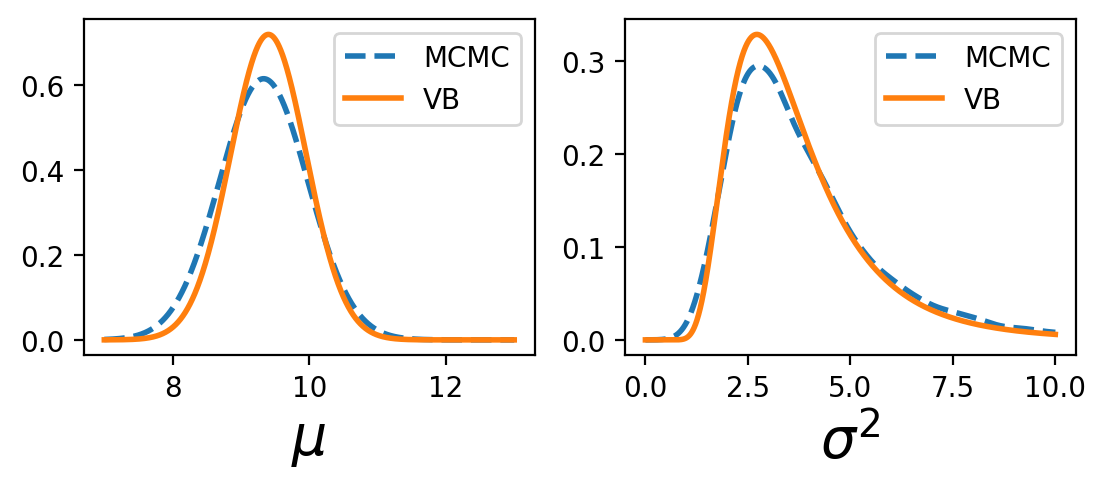

In [35]:

# Run VB
sum_y2 = np.sum(y ** 2)
muq = y_bar
sigma2q = 1  # initialize muq and sigma2q
eps = 1e-5
alphaq = alpha0 + n / 2
betaq = beta0 + sum_y2 / 2 - n * y_bar * muq + n * (muq ** 2 + sigma2q) / 2
parameter_new = [alpha0, beta0, mu0, sigma20]
stop = False

while not stop:
    parameter_old = parameter_new
    betaq = beta0 + sum_y2 / 2 - n * y_bar * muq + n * (muq ** 2 + sigma2q) / 2  # update beta_q
    sigma2q = 1 / (1 / sigma20 + n * alphaq / betaq)  # update sigma2_q
    muq = (mu0 / sigma20 + n * y_bar * alphaq / betaq) * sigma2q  # update mu_q
    parameter_new = np.array([alphaq, betaq, muq, sigma2q])
    if np.linalg.norm(parameter_new - parameter_old) < eps:
        stop = True

CPU_VB = np.sum(muq)  # CPU time taken to run VB

fontsize = 20
x = np.arange(7, 13, 0.0001)
yy_MCMC = norm.pdf(x, np.mean(mu_mcmc), np.std(mu_mcmc))
yy_VB = norm.pdf(x, muq, np.sqrt(sigma2q))
plt.subplot(2, 2, 1)
plt.plot(x, yy_MCMC, '--', x, yy_VB, '-', linewidth=2)
plt.xlabel('$\mu$', fontsize=fontsize)
plt.legend(['MCMC', 'VB'])

x = np.arange(0, 10, 0.0001)
kde_MCMC = gaussian_kde(sigma2_mcmc)
yy_MCMC = kde_MCMC(x)
def inverse_gamma_pdf(x):
    return np.exp(alphaq * np.log(betaq) - gammaln(alphaq) - (alphaq + 1) * np.log(x) - betaq / x)

yy_VB = inverse_gamma_pdf(x)
plt.subplot(2, 2, 2)
plt.plot(x, yy_MCMC, '--', x, yy_VB, '-', linewidth=2)
plt.legend(['MCMC', 'VB'])
plt.xlabel('$\sigma^2$', fontsize=fontsize)

plt.show()

In [36]:
CPU_MCMC

279925.14197891206

In [37]:
CPU_VB

9.401776910826245